# LightGBM на практике: регрессия и классификация на реальных данных

В этом ноутбуке мы разберём библиотеку **LightGBM** на двух задачах:

- **регрессия** на датасете *California Housing*;
- **классификация** на сложном многоклассовом датасете *Covertype*.

Мы рассмотрим:

- базовое применение `LGBMRegressor` и `LGBMClassifier`;
- ключевые идеи LightGBM (гистограммный алгоритм, leaf-wise рост деревьев, `num_leaves`, регуляризация);
- влияние важнейших гиперпараметров на качество (глубина, `num_leaves`, `feature_fraction`, `bagging_fraction`);
- визуализацию результатов и важностей признаков.

Базовые бэйзлайны (линейная регрессия, RandomForest, логистическая регрессия) уже разбирались в ноутбуке про XGBoost, поэтому здесь мы фокусируемся именно на **LightGBM**.

## 1. Импорт библиотек и подготовка данных

Используем те же датасеты, что и в ноутбуке про XGBoost:

- `fetch_california_housing` — задача регрессии (цены на жильё в Калифорнии);
- `fetch_covtype` — задача многоклассовой классификации типов лесного покрова.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from lightgbm import LGBMRegressor, LGBMClassifier

# Настройки отображения
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42

### 1.1. Датасет для регрессии: California Housing

Датасет содержит информацию о районах в Калифорнии и среднюю стоимость жилья в каждом районе.

Целевая переменная: `MedHouseVal` — средняя стоимость дома (в сотнях тысяч долларов).

In [2]:
california = fetch_california_housing(as_frame=True)
X_reg = california.data
y_reg = california.target

print('Shape:', X_reg.shape)
X_reg.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


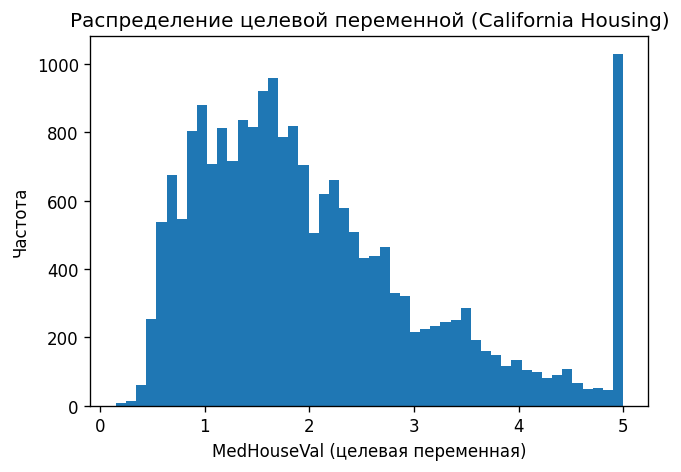

In [3]:
plt.hist(y_reg, bins=50)
plt.xlabel('MedHouseVal (целевая переменная)')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной (California Housing)')
plt.show()

In [4]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
X_reg_train.shape, X_reg_test.shape

((16512, 8), (4128, 8))

### 1.2. Датасет для классификации: Covertype

Датасет **Covertype** содержит данные о типе лесного покрова в разных участках территории США.

- Целевая переменная — тип лесного покрова (7 классов);
- Признаки — высота, уклон, расстояние до водоёмов/дорог, почвенные характеристики и т.д.

Возьмём случайную подвыборку для ускорения вычислений.

In [5]:
covtype = fetch_covtype(as_frame=True)
X_clf_full = covtype.data
y_clf_full = covtype.target

print('Полный датасет Covertype:', X_clf_full.shape)

# Подвыборка, например 50000 объектов
n_samples = 50000
rng = np.random.RandomState(RANDOM_STATE)
indices = rng.choice(len(X_clf_full), size=n_samples, replace=False)

X_clf = X_clf_full.iloc[indices].reset_index(drop=True)
y_clf = y_clf_full.iloc[indices].reset_index(drop=True)

X_clf.shape, y_clf.value_counts().sort_index()

Полный датасет Covertype: (581012, 54)


((50000, 54),
 Cover_Type
 1    18401
 2    24299
 3     3082
 4      222
 5      796
 6     1463
 7     1737
 Name: count, dtype: int64)

In [6]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)
X_clf_train.shape, X_clf_test.shape

((40000, 54), (10000, 54))

## 2. LightGBM: основные идеи и особенности

LightGBM — это высокопроизводительная реализация градиентного бустинга по деревьям, разработанная компанией Microsoft. Основные идеи:

### 2.1. Гистограммный алгоритм (histogram-based splits)

Вместо того, чтобы перебирать все возможные значения признака для поиска лучшего сплита, LightGBM сначала **биннинг-ует** каждый признак в небольшое число корзин (bins).

- Непрерывные значения заменяются индексом корзины (например, от 0 до 255);
- Для каждого листа и признака считается гистограмма по корзинам;
- Лучший сплит выбирается по гистограмме (а не по исходным значениям).

**Зачем это нужно?**

- значительное ускорение поиска сплитов;
- уменьшение потребления памяти;
- устойчивость к шуму и выбросам за счёт дискретизации.

### 2.2. Leaf-wise рост деревьев с ограничением глубины

В отличие от классического `depth-wise` роста (по уровням), LightGBM по умолчанию растит деревья **leaf-wise**:

- на каждом шаге выбирается лист с максимальным приростом качества (gain) и делится;
- в результате дерево получается несимметричным: некоторые ветви могут быть глубже других.

Чтобы избежать чрезмерной глубины, используется ограничение по `max_depth` или по `num_leaves`.

**Зачем это нужно?**

- leaf-wise рост позволяет получить более компактные деревья с тем же уровнем качества;
- модель часто достигает более высокого качества при меньшем числе итераций;
- но при слишком большом `num_leaves` есть риск переобучения — важно регулировать сложность.

### 2.3. Ключевой гиперпараметр `num_leaves`

`num_leaves` — максимальное число листьев в одном дереве.

- грубо соответствует экспоненте от `max_depth` (для полно сбалансированного дерева: `num_leaves \approx 2^{max_depth}`);
- чем больше листьев, тем выше аппроксимирующая способность дерева (ниже bias), но выше риск переобучения (выше variance).

**Практически:**

- начинать с умеренных значений (например, 31, 63, 127);
- увеличивать `num_leaves`, если модель недообучена;
- уменьшать, если видим сильное переобучение.

### 2.4. Параметры `feature_fraction` и `bagging_fraction`

- `feature_fraction` — доля признаков, используемых при построении каждого дерева;
- `bagging_fraction` — доля объектов, используемых для каждого дерева;
- обычно используются вместе с `bagging_freq` > 0, чтобы включить строчное сэмплирование.

**Зачем это нужно?**

- уменьшение коррелированности деревьев;
- снижение переобучения;
- ускорение обучения.

### 2.5. Параметры регуляризации

- `lambda_l1` — L1-регуляризация весов листьев;
- `lambda_l2` — L2-регуляризация весов листьев;
- `min_data_in_leaf` — минимальное число объектов в листе;
- `min_gain_to_split` — минимальный прирост качества, необходимый для сплита.

**Зачем это нужно?**

- L1/L2-регуляризация сглаживает предсказания и уменьшает переобучение;
- `min_data_in_leaf` предотвращает появление слишком узких, «шумовых» листьев;
- `min_gain_to_split` не позволяет делить, если прирост качества очень мал.

### 2.6. Как LightGBM работает с категориальными признаками

LightGBM умеет работать и с **чисто числовыми признаками**, и с **категориальными**, но требует явного указания категорий или специального типа столбца.

Есть два основных подхода:

1. **Простой (универсальный) — кодируем категории сами.**
   - Аналогично XGBoost: перед LightGBM всё категориальное превращаем в числовое:
     - One-Hot Encoding (`get_dummies`, `OneHotEncoder`);
     - Target/Mean Encoding;
     - Ordinal Encoding.
   - В этом случае мы просто передаём `LGBMRegressor` / `LGBMClassifier` обычный `numpy`/`pandas` с числами, и никаких дополнительных аргументов про категории не указываем.

2. **Нативные категориальные фичи LightGBM.**
   - Можно указать, какие столбцы являются категориальными, через параметр `categorical_feature` у `Dataset`/`fit`;
   - либо задать им тип `category` в `pandas` и передать список имён/индексов категориальных колонок:
     ```python
     cat_cols = ['brand', 'cpu_model']
     for col in cat_cols:
         X[col] = X[col].astype('category')

     model = LGBMClassifier(...)
     model.fit(X_train, y_train, categorical_feature=cat_cols)
     ```
   - В этом режиме LightGBM внутри сам кодирует категории и ищет по ним сплиты.

В этом ноутбуке все признаки уже числовые (в том числе потенциально категориальные признаки могут быть представлены набором dummy-колонок), поэтому мы используем LightGBM как **числовой бустинг** и не показываем нативный режим категориальных признаков.  
Для реальных задач с «сырыми» категориальными колонками (бренды, типы товаров, города и т.п.) имеет смысл либо заранее кодировать их, либо аккуратно использовать `categorical_feature`.


## 3. Регрессия с LGBMRegressor

Начнём с задачи регрессии на California Housing. Бэйзлайны уже обсуждались в ноутбуке по XGBoost, поэтому сразу строим модель LightGBM и анализируем её поведение.

### 3.1. Базовая модель LGBMRegressor

Соберём базовую модель с умеренными значениями параметров.

In [7]:
lgbm_reg_base = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l2=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm_reg_base.fit(X_reg_train, y_reg_train)
y_pred_lgbm = lgbm_reg_base.predict(X_reg_test)

mae_lgbm = mean_absolute_error(y_reg_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_reg_test, y_pred_lgbm))
r2_lgbm = r2_score(y_reg_test, y_pred_lgbm)

print(f'LGBMRegressor MAE:  {mae_lgbm:.4f}')
print(f'LGBMRegressor RMSE: {rmse_lgbm:.4f}')
print(f'LGBMRegressor R2:   {r2_lgbm:.4f}')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838

### 3.2. Визуализация предсказаний

Построим график "истинные vs предсказанные" значения для LGBMRegressor.

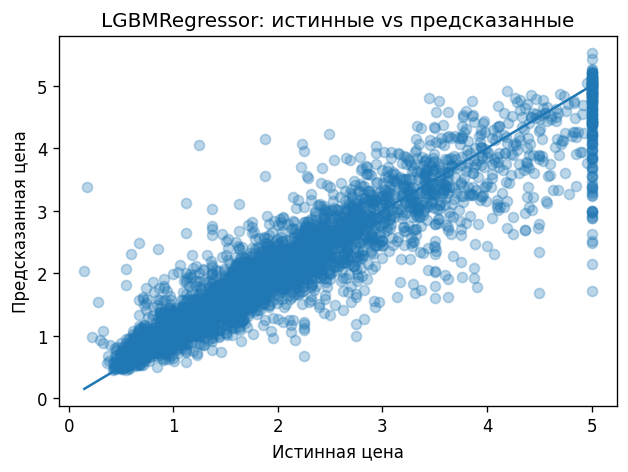

In [8]:
plt.figure()
plt.scatter(y_reg_test, y_pred_lgbm, alpha=0.3)
plt.xlabel('Истинная цена')
plt.ylabel('Предсказанная цена')
plt.title('LGBMRegressor: истинные vs предсказанные')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()])
plt.show()

## 4. Регрессия: влияние гиперпараметров LightGBM

Начнём с ключевого параметра `num_leaves`.

### 4.1. Эксперимент: `num_leaves`

Изменяем `num_leaves` и смотрим на MAE, RMSE и $R^2$.

In [9]:
leaves_list = [15, 31, 63, 127]
results_leaves = []

for leaves in leaves_list:
    model = LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=leaves,
        max_depth=-1,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        lambda_l2=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_reg_train, y_reg_train)
    preds = model.predict(X_reg_test)
    mae = mean_absolute_error(y_reg_test, preds)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    r2 = r2_score(y_reg_test, preds)
    results_leaves.append((leaves, mae, rmse, r2))

df_leaves = pd.DataFrame(results_leaves, columns=['num_leaves', 'MAE', 'RMSE', 'R2'])
df_leaves

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678

,num_leaves,MAE,RMSE,R2
0,15,0.308412,0.459024,0.839208
1,31,0.293775,0.443836,0.849673
2,63,0.281397,0.434494,0.855934
3,127,0.280364,0.435050,0.855565


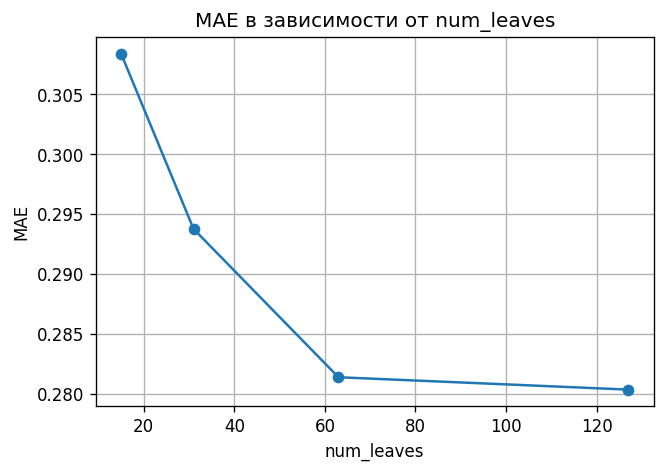

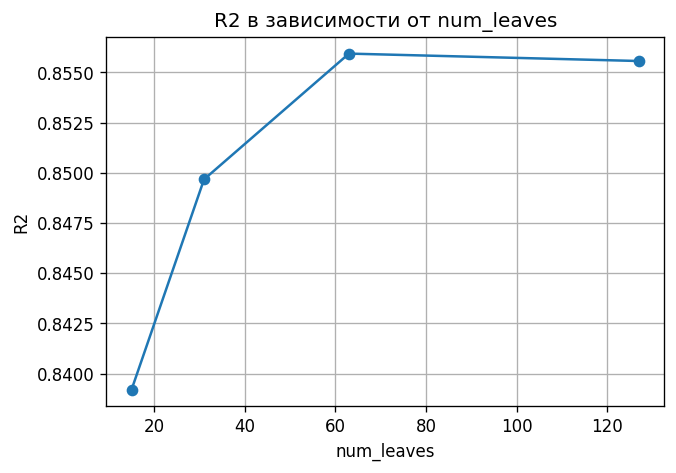

In [10]:
plt.figure()
plt.plot(df_leaves['num_leaves'], df_leaves['MAE'], marker='o')
plt.xlabel('num_leaves')
plt.ylabel('MAE')
plt.title('MAE в зависимости от num_leaves')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_leaves['num_leaves'], df_leaves['R2'], marker='o')
plt.xlabel('num_leaves')
plt.ylabel('R2')
plt.title('R2 в зависимости от num_leaves')
plt.grid(True)
plt.show()

### 4.2. Эксперимент: `feature_fraction` и `bagging_fraction`

Исследуем влияние сэмплирования по признакам и по объектам.

In [11]:
feature_fracs = [0.6, 0.8, 1.0]
bagging_fracs = [0.6, 0.8, 1.0]

results_sampling = []

for ff in feature_fracs:
    for bf in bagging_fracs:
        model = LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            num_leaves=63,
            max_depth=-1,
            feature_fraction=ff,
            bagging_fraction=bf,
            bagging_freq=1,
            lambda_l2=1.0,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        model.fit(X_reg_train, y_reg_train)
        preds = model.predict(X_reg_test)
        mae = mean_absolute_error(y_reg_test, preds)
        rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
        r2 = r2_score(y_reg_test, preds)
        results_sampling.append((ff, bf, mae, rmse, r2))

df_sampling = pd.DataFrame(results_sampling, columns=['feature_fraction', 'bagging_fraction', 'MAE', 'RMSE', 'R2'])
df_sampling

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701

,feature_fraction,bagging_fraction,MAE,RMSE,R2
0,0.6,0.6,0.287395,0.437972,0.853618
1,0.6,0.8,0.284528,0.434707,0.855793
2,0.6,1.0,0.283622,0.433568,0.856547
3,0.8,0.6,0.288718,0.438279,0.853413
4,0.8,0.8,0.283746,0.433707,0.856456
5,0.8,1.0,0.286651,0.438721,0.853118
6,1.0,0.6,0.291045,0.441786,0.851058
7,1.0,0.8,0.289098,0.440962,0.851613
8,1.0,1.0,0.287418,0.443165,0.850127


## 5. Регрессия: важности признаков

Посмотрим, какие признаки наиболее важны для LGBMRegressor на California Housing.

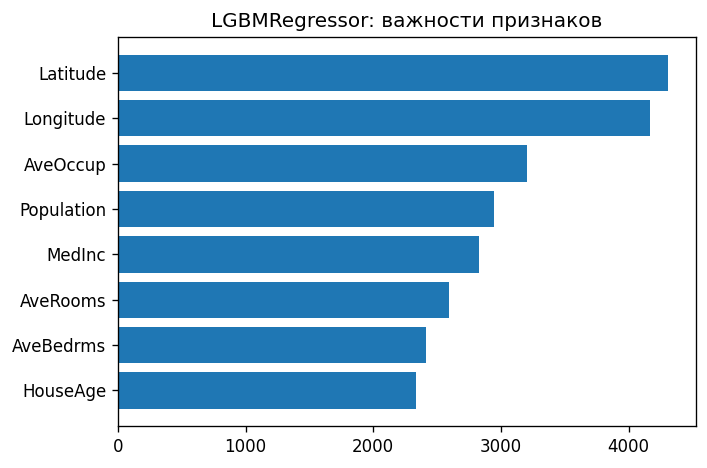

In [12]:
importances_reg = lgbm_reg_base.feature_importances_
feature_names_reg = X_reg.columns

order = np.argsort(importances_reg)

plt.figure(figsize=(6, 4))
plt.barh(range(len(importances_reg)), importances_reg[order])
plt.yticks(range(len(importances_reg)), feature_names_reg[order])
plt.title('LGBMRegressor: важности признаков')
plt.tight_layout()
plt.show()

## 6. Классификация с LGBMClassifier (многоклассовая задача)

Теперь применим LightGBM к многоклассовой задаче Covertype.

### 6.1. Базовая модель LGBMClassifier

Соберём базовый классификатор и оценим его качество по accuracy и macro-F1.

In [13]:
n_classes = y_clf.nunique()

lgbm_clf_base = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    num_leaves=63,
    max_depth=-1,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l2=1.0,
    objective='multiclass',
    num_class=n_classes,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm_clf_base.fit(X_clf_train, y_clf_train)
y_pred_lgbm_clf = lgbm_clf_base.predict(X_clf_test)

acc_lgbm = accuracy_score(y_clf_test, y_pred_lgbm_clf)
f1_lgbm = f1_score(y_clf_test, y_pred_lgbm_clf, average='macro')

print(f'LGBMClassifier accuracy: {acc_lgbm:.4f}')
print(f'LGBMClassifier macro-F1: {f1_lgbm:.4f}')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224

### 6.2. Матрица ошибок

Построим матрицу ошибок для LGBMClassifier.

In [14]:
cm = confusion_matrix(y_clf_test, y_pred_lgbm_clf)
cm

array([[3261,  398,    0,    0,    2,    0,   19],
       [ 317, 4494,   32,    0,    5,   11,    1],
       [   0,   25,  563,    1,    0,   28,    0],
       [   0,    0,   12,   31,    0,    1,    0],
       [   3,   69,    4,    0,   83,    0,    0],
       [   1,   26,   51,    3,    0,  212,    0],
       [  40,    5,    0,    0,    0,    0,  302]])

### 6.3. Классификация: влияние `num_leaves`

Исследуем влияние `num_leaves` на accuracy и macro-F1.

In [15]:
leaves_list_clf = [31, 63, 127, 255]
results_clf_leaves = []

for leaves in leaves_list_clf:
    model = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.1,
        num_leaves=leaves,
        max_depth=-1,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        lambda_l2=1.0,
        objective='multiclass',
        num_class=n_classes,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_clf_train, y_clf_train)
    pred = model.predict(X_clf_test)
    acc = accuracy_score(y_clf_test, pred)
    f1 = f1_score(y_clf_test, pred, average='macro')
    results_clf_leaves.append((leaves, acc, f1))

df_clf_leaves = pd.DataFrame(results_clf_leaves, columns=['num_leaves', 'accuracy', 'macro_F1'])
df_clf_leaves

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002053

,num_leaves,accuracy,macro_F1
0,31,0.8768,0.822036
1,63,0.8916,0.831861
2,127,0.9003,0.830158
3,255,0.9044,0.828944


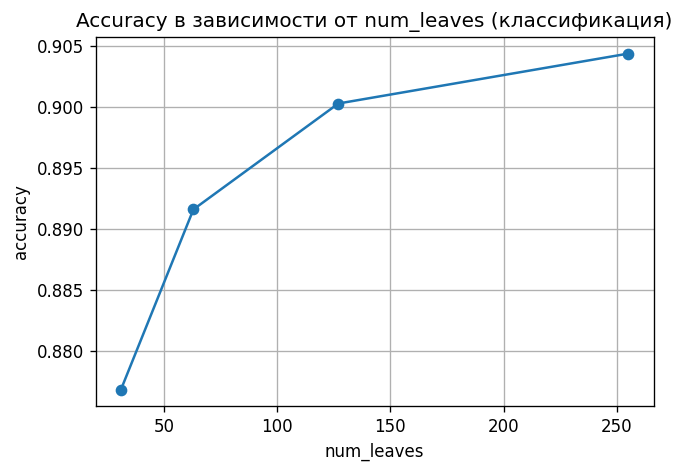

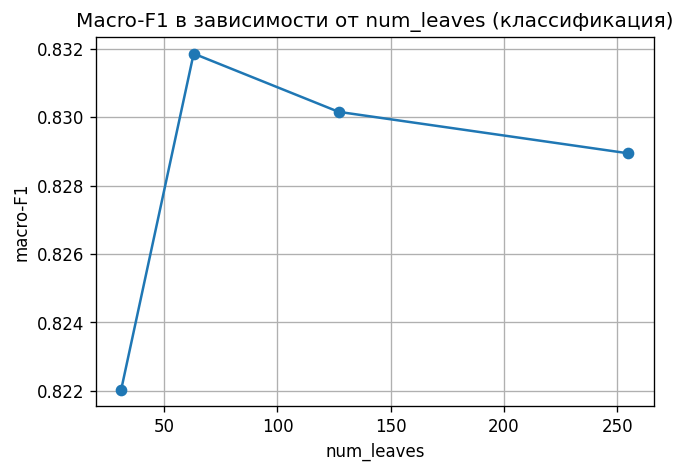

In [16]:
plt.figure()
plt.plot(df_clf_leaves['num_leaves'], df_clf_leaves['accuracy'], marker='o')
plt.xlabel('num_leaves')
plt.ylabel('accuracy')
plt.title('Accuracy в зависимости от num_leaves (классификация)')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_clf_leaves['num_leaves'], df_clf_leaves['macro_F1'], marker='o')
plt.xlabel('num_leaves')
plt.ylabel('macro-F1')
plt.title('Macro-F1 в зависимости от num_leaves (классификация)')
plt.grid(True)
plt.show()

### 6.4. Важности признаков (классификация)

Посмотрим, какие признаки оказывают наибольшее влияние на решение LGBMClassifier.

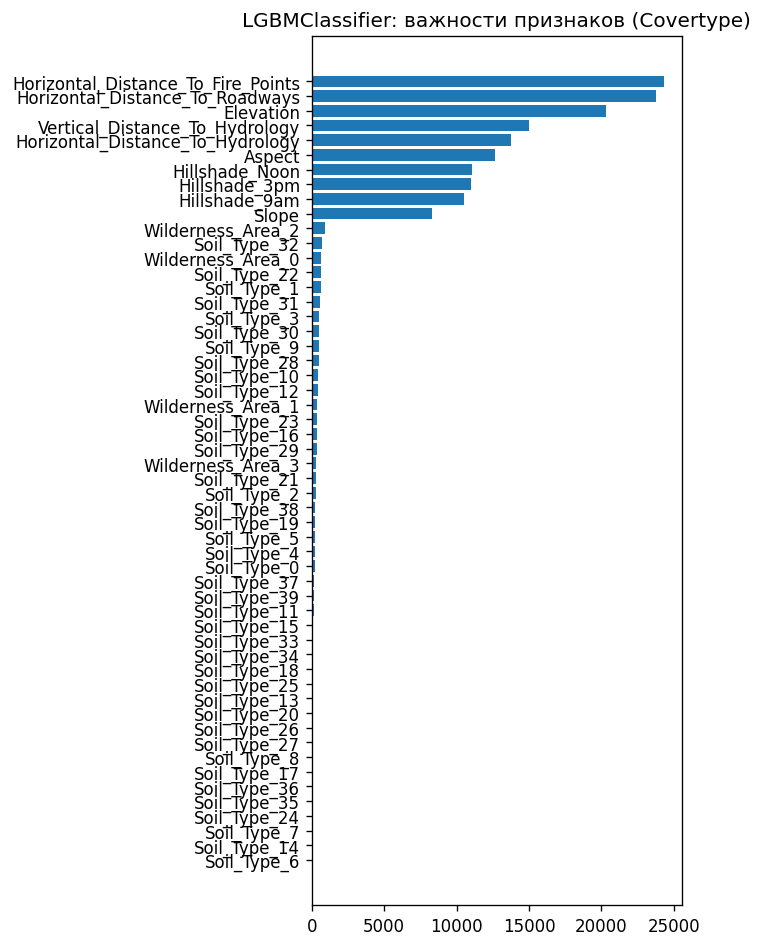

In [17]:
importances_clf = lgbm_clf_base.feature_importances_
feature_names_clf = X_clf.columns

order_clf = np.argsort(importances_clf)

plt.figure(figsize=(6, 8))
plt.barh(range(len(importances_clf)), importances_clf[order_clf])
plt.yticks(range(len(importances_clf)), feature_names_clf[order_clf])
plt.title('LGBMClassifier: важности признаков (Covertype)')
plt.tight_layout()
plt.show()

## 7. Выводы

В этом ноутбуке мы:

- применили **LGBMRegressor** к задаче регрессии California Housing и увидели, что он даёт высокое качество на табличных данных;
- исследовали влияние `num_leaves`, `feature_fraction` и `bagging_fraction` на качество регрессии;
- проанализировали важности признаков для регрессии;
- применили **LGBMClassifier** к многоклассовой задаче Covertype и изучили его качество по accuracy и macro-F1;
- посмотрели, как `num_leaves` влияет на качество классификации и какие признаки оказываются наиболее важными.

Основные практические выводы:

- LightGBM — очень быстрый и точный алгоритм градиентного бустинга, особенно эффективный на больших табличных датасетах;
- параметр `num_leaves` является ключевым регулятором сложности дерева и должен настраиваться аккуратно;
- сэмплирование по признакам и объектам (`feature_fraction`, `bagging_fraction`) помогает уменьшать переобучение и ускорять обучение;
- анализ важностей признаков позволяет интерпретировать модель и лучше понять структуру данных.

В отдельном ноутбуке можно аналогично разобрать **CatBoost** и затем сравнить все три бустинга (XGBoost, LightGBM, CatBoost) на одних и тех же задачах.